# <center> 
# <center> 3e. ARMA Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['forecast']
RPY.load_R_packages(R_packages)

R packages loaded: forecast


Load Python packages

In [4]:
pth_packages = ['pandas_datareader']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, pandas_datareader.data as web
import datetime as dt, matplotlib.pyplot as plt, matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Data
U.S. Labor Force Participation Rate, monthly ([Source](https://fred.stlouisfed.org/series/CIVPART))

In [5]:
CIVPART = web.DataReader('CIVPART', 'fred', start=dt.datetime(1990,1,1),end=dt.datetime(2025, 1, 1))
CIVPART = CIVPART.asfreq('MS') # set to monthly frequency ('MS' = Month Start)
CIVPART_c = CIVPART.diff().dropna()

Plot the data

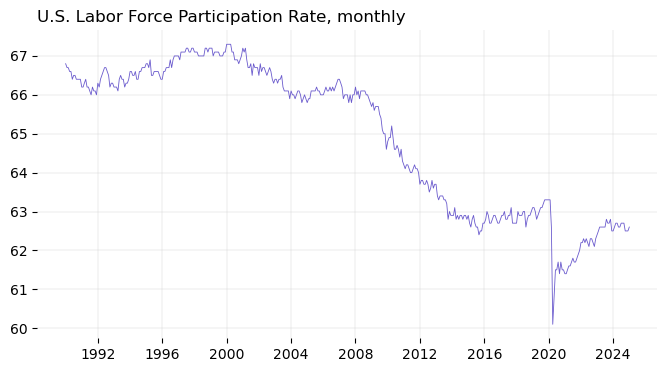

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(CIVPART, '-', color='slateblue', linewidth=0.6)
plt.title('U.S. Labor Force Participation Rate, monthly', loc='left')
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.show()

.

# 2. ACF and PACF

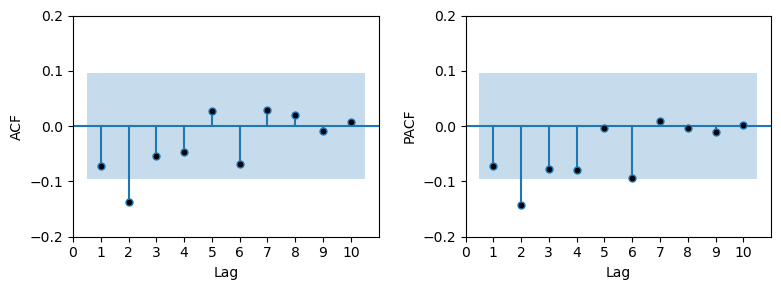

In [7]:
lag_max = 10

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs = axs.flatten()

plot_acf(CIVPART_c, lags=lag_max, alpha=0.05, zero=False, mfc='black', 
         bartlett_confint=False, title=None, ax=axs[0])
axs[0].set_ylabel('ACF')
axs[0].set_xticks(np.arange(0, lag_max+1, step=1))

plot_pacf(CIVPART_c, lags=lag_max, alpha=0.05, zero=False, mfc='black', 
          title=None, ax=axs[1])
axs[1].set_ylabel('PACF')
axs[1].set_xticks(np.arange(0, lag_max+1, step=1))

for ax in axs:
    ax.set_ylim(-0.2,0.2)
    ax.set_xlabel('Lag')

fig.tight_layout() 
plt.show() 

Both ACF and PACF have a significant spike at lag 2. Neither extends to higher lags substantially longer than the other. Hence, AR(2,2) model is a suitable candidate for this series..

# 3. ARMA automatic model selection
Let’s take a look at the best-fitting model selected by `auto_arima()` from the R package [forecast](https://pkg.robjhyndman.com/forecast/).

In [8]:
ro.globalenv['CIVPART_c'] = CIVPART_c # copy data from Python to R

In [9]:
%%R
ARMA_model_c <- forecast::auto.arima(CIVPART_c)
ARMA_model_c

Series: CIVPART_c 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
          ar1     ar2     ma1      ma2     mean
  -0.3097  0.5097  0.1990  -0.6948  -0.0099
   0.1182  0.1137  0.0967   0.0926   0.0057

0.03398:  log likelihood = 116.71
AIC=-221.41   AICc=-221.21   BIC=-197.17


`auto.arima()` confirms ARMA(2,2) as a suitable model.  

# 4. `i=1` option

The middle digit in `ARIMA(p,i,q)` indicates that the differenced data is stationary (`i=0`). If we use the original level data, `auto.arima()` concludes that it is non-stationary (`i=1`). 

In [10]:
ro.globalenv['CIVPART'] = CIVPART # copy data from Python to R

In [11]:
%%R
ARMA_model <- forecast::auto.arima(CIVPART)
ARMA_model

Series: CIVPART 
ARIMA(2,1,2) with drift 

Coefficients:
          ar1     ar2     ma1      ma2    drift
  -0.3097  0.5097  0.1990  -0.6948  -0.0099
   0.1182  0.1137  0.0967   0.0926   0.0057

0.03399:  log likelihood = 116.71
AIC=-221.41   AICc=-221.21   BIC=-197.17


If we use non-stationary data in ARIMA model specification and set `i=1`, `ARIMA` will automatically difference the data, use it to estimate the coefficients, and then the post-estimation method `get_forecast` will add up the forecasted data differences to output a forecast in the original levels. In contrast, using differenced data with `i=0` would result in a forecast of data differences.

# 5. Estimation

Fit `ARIMA(p=2, i=1, q=2)` model, using original level data with `i=1`

In [12]:
%%R
ARMA_model <- stats::arima(CIVPART, order=c(2,1,2))

# 6. Forecast

In [13]:
%%R
h_steps <- 6 # Set the forecast time horizon
ARMA_forecast <- stats::predict(ARMA_model, n.ahead=h_steps)

In [14]:
ARMA_forecast = ro.globalenv['ARMA_forecast'] # copy data from R to Python
h_steps = int(ro.globalenv['h_steps'][0])

Create a time index for the forecast (see file "1c. Time Series in Python" for details)

In [15]:
id = CIVPART.index 
id_f = pd.date_range(start=id[-1]+pd.DateOffset(1), periods=h_steps, freq=id.freq) 
ARMA_f = pd.DataFrame(index=id_f, data={'forecast': ARMA_forecast[0]}) 

# 7. Plot

Plot part of the original series and the forecast (see file "1d. Graphics in Python" for details)

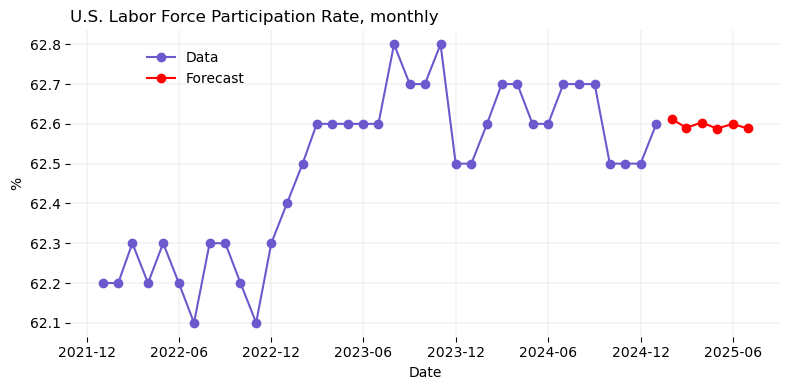

In [16]:
start_plot = pd.to_datetime('2022-01-01') 
CIVPART_s = CIVPART[CIVPART.index >= start_plot] 

plt.figure(figsize=(8, 4))
plt.plot(CIVPART_s.index, CIVPART_s['CIVPART'], label='Data', color='slateblue', linestyle='-', marker='o')
plt.plot(ARMA_f.index, ARMA_f['forecast'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('U.S. Labor Force Participation Rate, monthly', loc='left')
plt.legend(loc=(0.1, 0.8), frameon=False) 
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()

 Plot subset of data and 1-step ahead in-sample forecasts

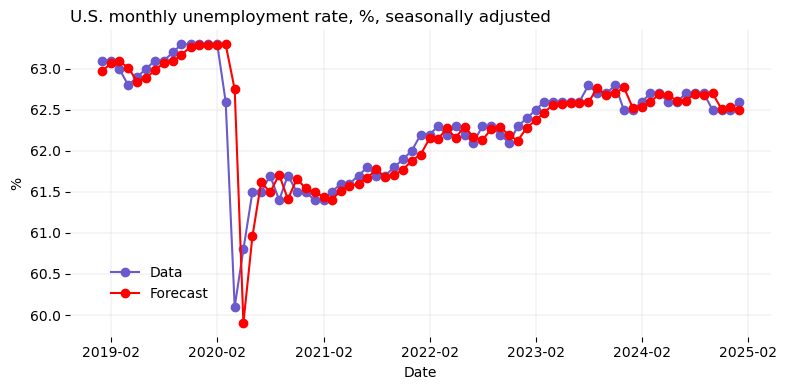

In [17]:
import warnings
warnings.filterwarnings("ignore")
data = CIVPART
f_start = pd.to_datetime('2019-01-01')
T = len(data)
y = data[data.index >= f_start].copy()
s = len(y)
y['y.hat'] = 0

for j in range(s):
    t = T-s+j
    ydat = data.iloc[:t]      
    ro.globalenv['ydat'] = ydat # copy data from Python to R
    ro.r('''
    yh <- stats::predict(stats::arima(ydat, order=c(2,1,2),method='ML'), n.ahead=1)
    ''')
    yh = ro.globalenv['yh'] # copy data from R to Python    
    y.at[y.index[j], 'y.hat'] = yh[0]

plt.figure(figsize=(8, 4))
# plot data
plt.plot(y.index, y['CIVPART'], label='Data', color='slateblue', linestyle='-', marker='o')
# plot forecast
plt.plot(y.index, y['y.hat'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('U.S. monthly unemployment rate, %, seasonally adjusted', loc='left')
plt.legend(loc=(0.05, 0.1), frameon=False) 
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()